# Practical exercise 2

*authors: Asan Agibetov, Georg Dorffner*

In this exercise you will learn how to use Convolutional Neural Networks (CNNs), and build a simple handwritten digit recognition system based on CNN. The acquired knowledge in this exercise will also be important for the next exercise, where you will build a CNN for the recognition of medical images.

## Package imports and global settings

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
import itertools as it

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data preparation

We will be using the [MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/) to demonstrate the application of convolutional neural networks. Pytorch has a related package - `torchvision`, which contains a set of convenience functions to prepare the commonly used datasets. In particular we will use `torchvision.datasets.MNIST` callable which will prepare MNIST data for us.

In [3]:
# Hyper Parameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001

train_dataset = torch.load("./data/train.limited.pt")
test_dataset = torch.load("./data/test.limited.pt")

Due to the size and computational resource limitation imposed by Microsfot Azure Cloud platform for the free accounts, we will only use a fraction of available images both during training and testing. If you are preparing these exercises on your local machine, and have enough computational resources (any modern i5/i7 Intel CPU (or equivalent) machine), you could (and maybe you should) use the full dataset. 

*Contact your instructors for the full dataset.*

`torchvision.datasets.*` give us access to the raw (pixel intensities) and processed data (tensor representation). Having access to the tensor representation of images, we can now build *input pipeliens* for the CNNs which will load data in *batches*. We need the batch loading functionality for the *mini-batch stocastic optimization*. These pipelines are implemented in `torch.utils.data.DataLoader` class, which loads mini-batches (random samples) of our data in parallalel.

In [4]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

The dataset is split into *train* and *test* subsets, each element of either dataset contains one $28 \times 28$ image with labels, which we need to predict from image data.

torch.Size([1, 28, 28])
5


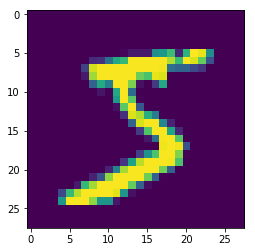

In [5]:
img, label = train_dataset[0]
print(img.shape)
print(label)
plt.imshow(img.squeeze().numpy())

torch.Size([1, 28, 28])
7


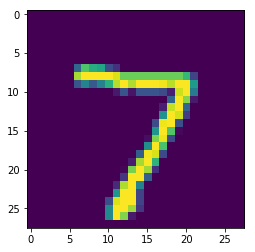

In [6]:
img, label = test_dataset[0]
print(img.shape)
print(label)
plt.imshow(img.squeeze().numpy())

Since we are limiting the number of samples of the original dataset (we pick a subset at random), we might have imbalanced classes, i.e., some classes might have much more samples than other. Below we simply count the number of images (samples) in each subset (train and test), make sure that the classes are "balanced", otherwise re-run the cells in the *Data preparation* section untill you get balanced classes.

In [7]:
from collections import Counter

tr_labels = [y for x, y in train_dataset]
te_labels = [y for x, y in test_dataset]
print(Counter(tr_labels))
print(Counter(te_labels))

Counter({7: 117, 1: 116, 4: 105, 9: 100, 2: 99, 0: 97, 6: 94, 3: 93, 5: 92, 8: 87})
Counter({1: 28, 4: 28, 7: 24, 9: 21, 5: 20, 6: 20, 0: 17, 2: 16, 3: 16, 8: 10})


## Convolutional Neural Network

We finally come to the central part of this exercise - the definition of a CNN. As you can see, a CNN is defined as a `pytorch` module consisting of *convolutional, maxpooling* and non-linear activation layers as you saw in lecture. In particular,

* `nn.Conv2D(n, m, kernel_size=k)` will take *n* 2d signals (images) and produce *m* 2d signals (filters) by convolving each of the *n* signals with a kernel (sliding window) of a size $k \times k$. Note that each of the *m* produced filters will have the dimension *N - k + 1*, where $N \times N$ is the dimension of the input 2d signal.
* `MaxPool2D(h)` will take the maximum value in the previous layer (usually on the produced filter images) in the $h \times h$ region. You should understand that the *maxpooling* layer will produce the output 2d signal of dimenions $\frac{M}{h} \times \frac{M}{h}$, where $M \times M$ - the size of the filter on which we perform *maxpooling*.
* `BatchNorm(m)` is a layer which is goind to normalize all values for the current batch, to avoid the problem of the vanishing gradients (i.e., it will make sure that the *learning* is not slowed down by the neurons with close to zero activations)

The convolutional pipeline of a CNN is succeded by the *classification* pipeline, consisting of *fully connected* layers (one or many). In particular, the fully connected layer will have to take as input the unwrapped 1d vector representation of the output of the convolution pipeline. You will have to manually determine the final dimensions of the fully connected layers. For instance, if the final layer in the convolution pipeline (usually a pooling layer) produced a 2d output of $\frac{M}{h} \times \frac{M}{h}$ dimensions, then the fully connected layer will map $\mathbb{R}^{\frac{M}{h} * \frac{M}{h}} \mapsto C$, where $C$ is the number of final categories (e.g., $C=2$ for binary classifications).

In [8]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            # nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # self.fc = nn.Linear(7*7*32, 10) 
        self.fc = nn.Linear(4*4*32, 10)
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 
    
cnn = CNN()

### Exercise 2.1

Here, we start with images of $28 \times 28$ dimensions, and finally have a fully connected layer which maps vectors in $\mathbf{R}^{32*4*4}$ to $C=10$ (10 categories for 0-9 digits). Explain the derivation of the final size of the fully connected layer from the input images with the formulas provided for the convolutional and pooling layers above.

*Hint: the fully connected layer will receive $32$ images each of size $4 \times 4$*

### Exercise 2.2

What would be the size of the fully connected layer after a convolution pipeline consisting of

1. `nn.Conv2d(1, 16, kernel_size=7)` with $7 \times 7$ kernel
2. `nn.MaxPool2d(4)`
1. `nn.Conv2d(16, 32, kernel_size=5)` with $5 \times 5$ kernel
2. `nn.MaxPool2d(2)`

applied to images of dimensions $64 \times 64$?

*Hint: beware that some choice of dimensions may be incompatible, and may break the convolution pipeline*

### Training and evaluation

Below we train our CNN with stochastic mini-batch gradient descent. Note that we are only training for 10 epochs due to resource limitations, try to train for more epochs (try to get the loss error go to zero as much as possible) if you are doing these exercises on a local machine.

In [9]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Epoch [1/10], Iter [5/10] Loss: 1.9815
Epoch [1/10], Iter [10/10] Loss: 1.6853
Epoch [2/10], Iter [5/10] Loss: 1.3273
Epoch [2/10], Iter [10/10] Loss: 1.0773
Epoch [3/10], Iter [5/10] Loss: 0.9555
Epoch [3/10], Iter [10/10] Loss: 0.8225
Epoch [4/10], Iter [5/10] Loss: 0.6269
Epoch [4/10], Iter [10/10] Loss: 0.5780
Epoch [5/10], Iter [5/10] Loss: 0.5035
Epoch [5/10], Iter [10/10] Loss: 0.3871
Epoch [6/10], Iter [5/10] Loss: 0.3036
Epoch [6/10], Iter [10/10] Loss: 0.3735
Epoch [7/10], Iter [5/10] Loss: 0.2746
Epoch [7/10], Iter [10/10] Loss: 0.2554
Epoch [8/10], Iter [5/10] Loss: 0.2040
Epoch [8/10], Iter [10/10] Loss: 0.2227
Epoch [9/10], Iter [5/10] Loss: 0.1880
Epoch [9/10], Iter [10/10] Loss: 0.2620
Epoch [10/10], Iter [5/10] Loss: 0.1240
Epoch [10/10], Iter [10/10] Loss: 0.2413


Finally, we evaluate the *accuracy* of the CNN on the test dataset.

In [10]:
# Test the Model
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy of the model on the %d test images: %d %%' % (len(test_dataset), 100 * correct / total))

Test Accuracy of the model on the 200 test images: 95 %


### Exercise 2.3

Try to train *deeper* CNNs, make sure that compute the dimensions of the layers appropriately as you continuously downsample images (as a result of convolutions and maxpoling). Report differences with the provided CNN: convergence rate, i.e., time it takes to reduce loss error close to $0$ (within epsilon), contrast the plots of loss errors, compare test accuracy of the models.